In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
df = pd.read_csv("data/cleaned data/merged_data.csv")
df = df.dropna()

In [3]:
characteristics = ["NumberofSchools", "DistrictEnrollment", "PercentofGiftedStudents",
        "CharterSchoolEnrollment", "GeographicSizeofDistrict", "AmericanIndian_AlaskanNative", "Asian", "NativeHawaiianorotherPacificIslander",
       "Black", "Hispanic", "White", "TwoOrMoreRaces", "EconomicallyDisadvantaged", "EnglishLearner", "SpecialEducation", "Female", "Male", 
       "Homeless", "MilitaryConnected", "perc_unconnected_students", "Latitude", "Longitude"]

In [4]:
# Separate districts with high and low time spent in person 
high_policy = df[df["In_Person"] > df["In_Person"].median()]
low_policy = df[df["In_Person"] <= df["In_Person"].median()]

# Perform spatial matching
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(low_policy[characteristics])

distances, indices = nn.kneighbors(high_policy[characteristics])
matched_pairs = pd.DataFrame({
    "high_policy_index": high_policy.index,
    "low_policy_index": low_policy.iloc[indices.flatten()].index,
    "distance": distances.flatten()
})

<Axes: xlabel='In_Person', ylabel='Count'>

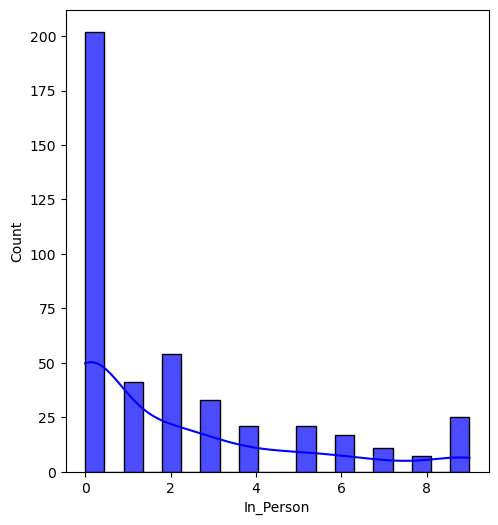

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df["In_Person"], kde=True, bins=20, color="blue", alpha=0.7)

In [6]:
# Add column for difference in test scores 
df["english_diff"] = df["mean_proficient_english_2022"] - df["mean_proficient_english_2019"]
df["math_diff"] = df["mean_proficient_math_2022"] - df["mean_proficient_math_2019"]

In [7]:
# Add test score differences for matched pairs
matched_pairs["english_diff_high"] = df.loc[matched_pairs["high_policy_index"], "english_diff"].values
matched_pairs["math_diff_high"] = df.loc[matched_pairs["high_policy_index"], "math_diff"].values
matched_pairs["english_diff_low"] = df.loc[matched_pairs["low_policy_index"], "english_diff"].values
matched_pairs["math_diff_low"] = df.loc[matched_pairs["low_policy_index"], "math_diff"].values

matched_pairs["english_diff_pairs"] = (
    df.loc[matched_pairs["high_policy_index"], "english_diff"].values -
    df.loc[matched_pairs["low_policy_index"], "english_diff"].values
)
matched_pairs["math_diff_pairs"] = (
    df.loc[matched_pairs["high_policy_index"], "math_diff"].values -
    df.loc[matched_pairs["low_policy_index"], "math_diff"].values
)

# Perform t-tests or difference of means
from scipy.stats import ttest_ind

english_scores = matched_pairs["english_diff_pairs"].dropna()
math_scores = matched_pairs["math_diff_pairs"].dropna()

english_ttest = ttest_ind(english_scores, [0] * len(english_scores))
math_ttest = ttest_ind(math_scores, [0] * len(math_scores))

print("English T-Test:", english_ttest)
print("Math T-Test:", math_ttest)


English T-Test: TtestResult(statistic=2.1775987193595165, pvalue=0.030057019786765674, df=376.0)
Math T-Test: TtestResult(statistic=2.427299640020905, pvalue=0.01568061117645827, df=376.0)


In [8]:
matched_pairs

,high_policy_index,low_policy_index,distance,english_diff_high,math_diff_high,english_diff_low,math_diff_low,english_diff_pairs,math_diff_pairs
0,15,77,3.675786,-9.111111,-4.944444,-3.481944,-4.309722,-5.629167,-0.634722
1,21,408,3.936410,-3.837500,-2.325000,-9.987500,-0.412500,6.150000,-1.912500
2,24,520,2.251223,-3.933333,-2.966667,-5.200000,-4.100000,1.266667,1.133333
3,28,361,3.598863,-3.300000,-3.700000,-6.866667,2.300000,3.566667,-6.000000
4,33,473,5.132482,-4.833333,-4.200000,-2.066667,-6.866667,-2.766667,2.666667
...,...,...,...,...,...,...,...,...,...
184,738,75,2.109739,-4.600000,0.750000,-8.450000,-5.950000,3.850000,6.700000
185,740,272,3.042653,-5.371429,-6.157143,-4.320000,-5.300000,-1.051429,-0.857143
186,741,170,2.676193,-6.650000,-1.550000,-1.750000,-4.250000,-4.900000,2.700000
187,743,550,2.095605,1.080000,0.680000,3.825000,-1.800000,-2.745000,2.480000


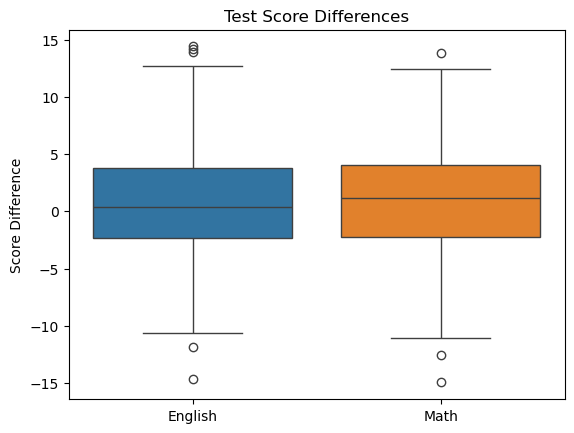

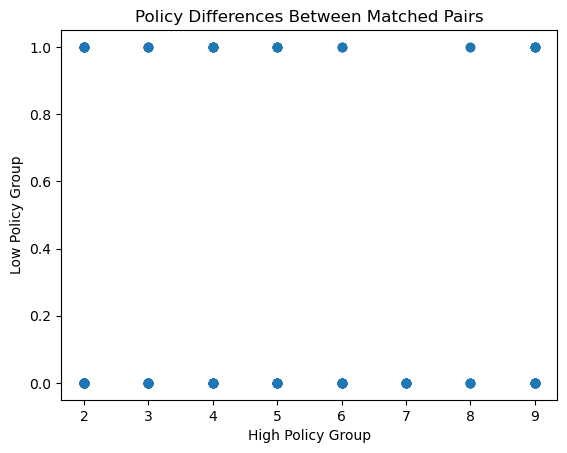

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of score differences
sns.boxplot(data=matched_pairs[["english_diff_pairs", "math_diff_pairs"]])
plt.title("Test Score Differences")
plt.ylabel("Score Difference")
plt.xticks([0, 1], ["English", "Math"])
plt.show()

# Scatter plot to visualize matches
plt.scatter(df.loc[matched_pairs["high_policy_index"], "In_Person"],
            df.loc[matched_pairs["low_policy_index"], "In_Person"])
plt.title("Policy Differences Between Matched Pairs")
plt.xlabel("High Policy Group")
plt.ylabel("Low Policy Group")
plt.show()

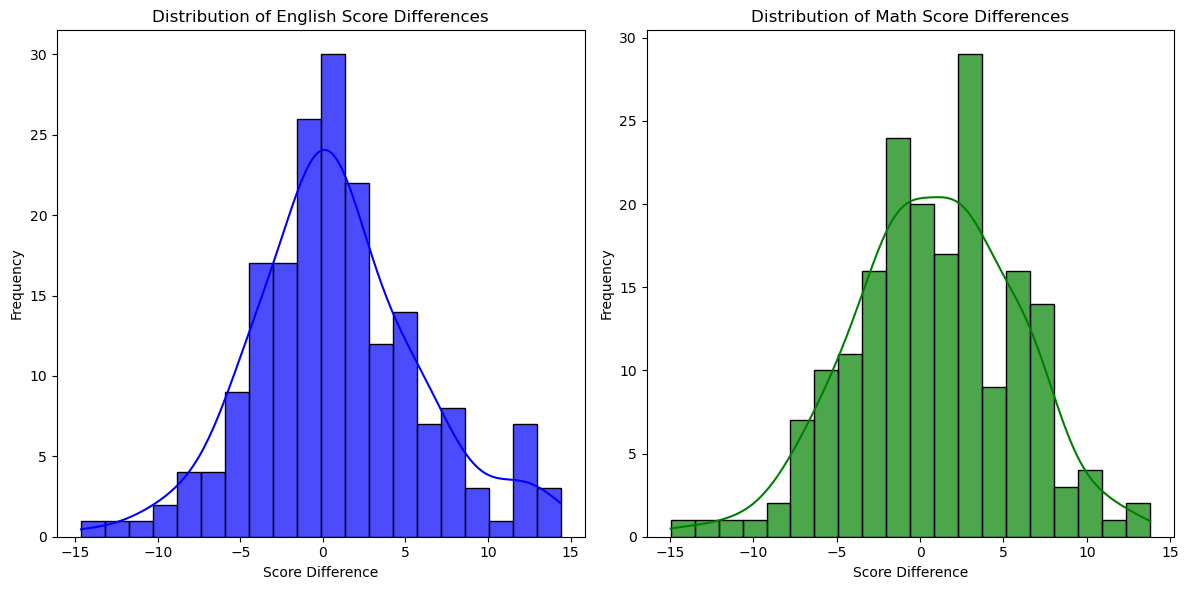

In [10]:
# Histogram of differences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(matched_pairs["english_diff_pairs"], kde=True, bins=20, color="blue", alpha=0.7)
plt.title("Distribution of English Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(matched_pairs["math_diff_pairs"], kde=True, bins=20, color="green", alpha=0.7)
plt.title("Distribution of Math Score Differences")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


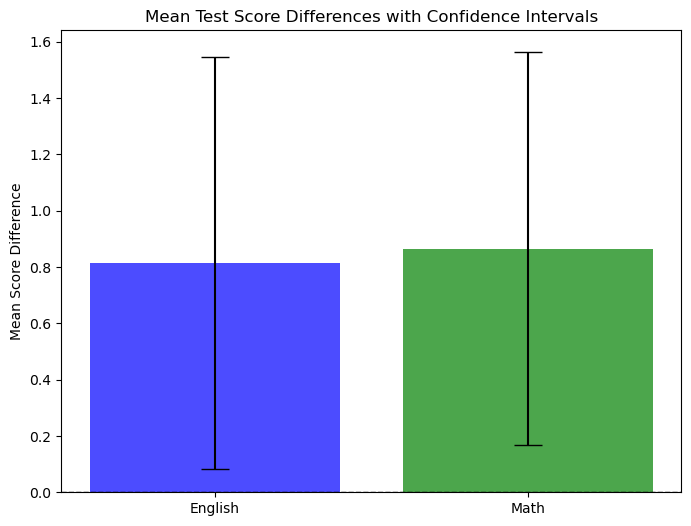

In [11]:
# Mean differences with confidence intervals
mean_diffs = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].mean()
std_diffs = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].std()
sample_sizes = matched_pairs[["english_diff_pairs", "math_diff_pairs"]].count()
conf_intervals = 1.96 * (std_diffs / sample_sizes ** 0.5)

plt.figure(figsize=(8, 6))
plt.bar(["English", "Math"], mean_diffs, yerr=conf_intervals, capsize=10, color=["blue", "green"], alpha=0.7)
plt.title("Mean Test Score Differences with Confidence Intervals")
plt.ylabel("Mean Score Difference")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.show()


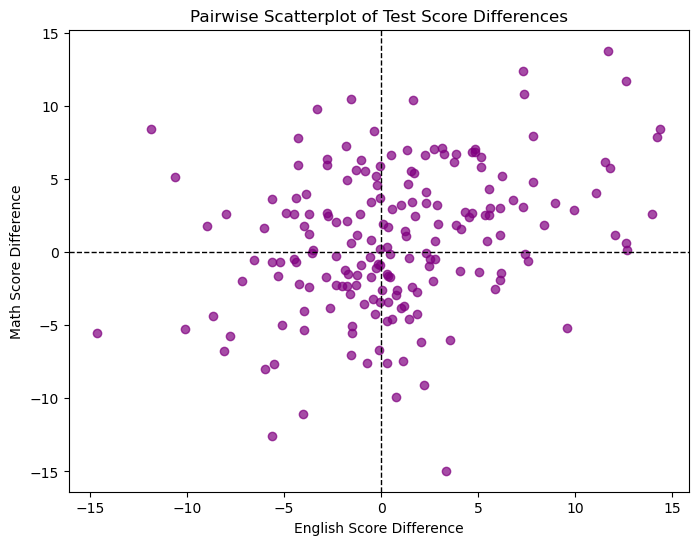

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(matched_pairs["english_diff_pairs"], matched_pairs["math_diff_pairs"], alpha=0.7, color="purple")
plt.title("Pairwise Scatterplot of Test Score Differences")
plt.xlabel("English Score Difference")
plt.ylabel("Math Score Difference")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

In [13]:
import folium

# Create a base map centered on Pennsylvania
map_pa = folium.Map(location=[40.9, -77.8], zoom_start=7)  # Centered approximately on Pennsylvania

# Add matched pairs to the map
for _, pair in matched_pairs.iterrows():
    # Get coordinates for the high-policy and low-policy districts
    high_coords = df.loc[pair["high_policy_index"], ["Latitude", "Longitude"]].values
    low_coords = df.loc[pair["low_policy_index"], ["Latitude", "Longitude"]].values

    # Add markers for each district
    folium.Marker(location=high_coords, popup="High Policy Group", icon=folium.Icon(color="blue")).add_to(map_pa)
    folium.Marker(location=low_coords, popup="Low Policy Group", icon=folium.Icon(color="green")).add_to(map_pa)

    # Add a line connecting the matched districts
    folium.PolyLine([high_coords, low_coords], color="red", weight=2).add_to(map_pa)

# Save map as an HTML file or display it in a notebook
map_pa.save("matched_pairs_map.html")
map_pa